In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/src")

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

import matplotlib.pyplot as plt

from modules import *
from losses import *
from utils import random_binary_mask, get_synthetic_dataset, plot_synthetic_dataset,cosine_scheduler

In [4]:
synthetic_X, synthetic_y = get_synthetic_dataset()

normalized_synthetic_X = (synthetic_X - synthetic_X.min()) / (synthetic_X.max() - synthetic_X.min())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
synthetic_dataset = TensorDataset(synthetic_X, synthetic_y)

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


AE Training finished!


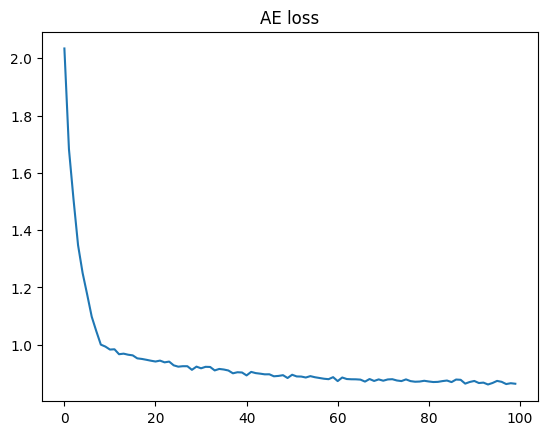

In [7]:
synthetic_layer_dims = [13, 10, 8]

BATCH_SIZE = 32
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

ae = MLPAutoEncoder(synthetic_layer_dims)
criterion = SparseLoss(pretrain=True)

ae = ae.to(device)

LR = 1e-3
EPOCHS = 100

optimizer = optim.Adam(ae.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0

    for x, y in synthetic_dataloader:

        x = x.to(device)

        x_hat = ae(x)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('AE Training finished!')
plt.plot(losses)
plt.title("AE loss")
plt.show()

------------------------------
AE Pre-training
------------------------------


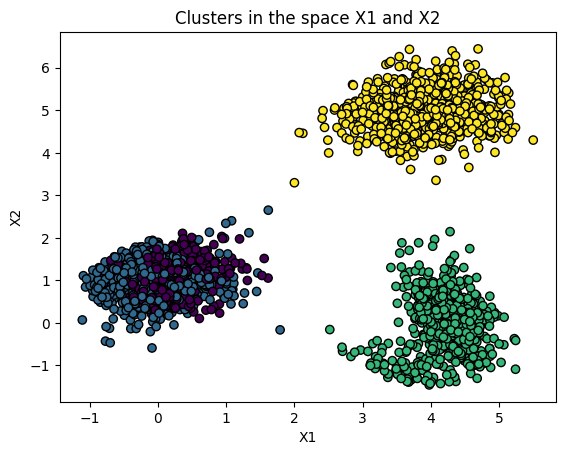

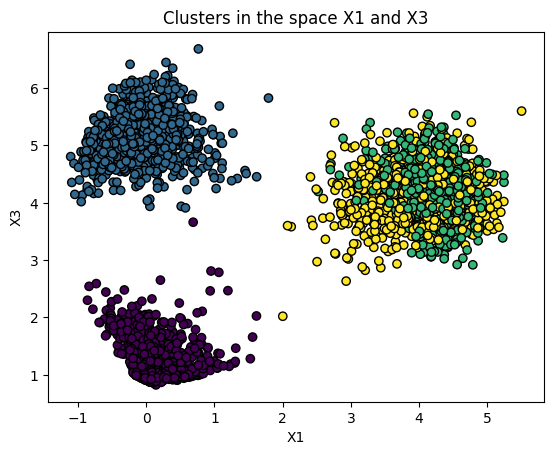

In [8]:
synthetic_X_hat = ae(synthetic_X.to(device))
print("------------------------------")
print("AE Pre-training")
print("------------------------------")
plot_synthetic_dataset(synthetic_X_hat.cpu().detach().numpy(), synthetic_y)

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

ALL Training finished!


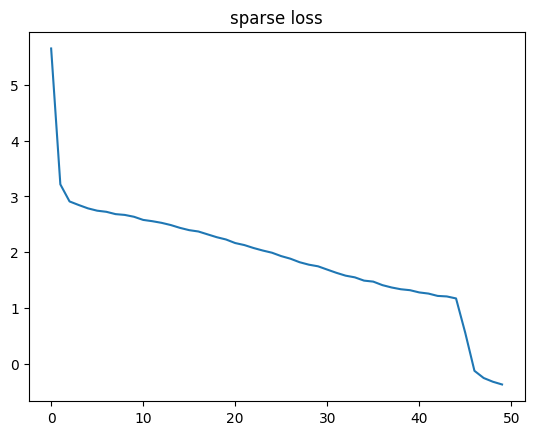

In [9]:
BATCH_SIZE = 32
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

gnn = GatingNN(13, 16)
gnn = gnn.to(device)

LR = 1e-3
EPOCHS = 50

optimizer = optim.Adam(list(gnn.parameters()) + list(ae.parameters()), lr=LR)
criterion = SparseLoss(pretrain=False)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS)

    for x, y in synthetic_dataloader:

        x = x.to(device)

        x_z, z, u = gnn(x)
        x_hat = ae(x)
        x_z_hat = ae(x_z)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat,x_z_hat,z,u,lmbd)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('ALL Training finished!')
plt.plot(losses)
plt.title("sparse loss")
plt.show()

In [10]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)
X_z_hat = ae(X_Z)
X_hat = ae(X)

------------------------------
AE Fine-tuned , display for X
------------------------------


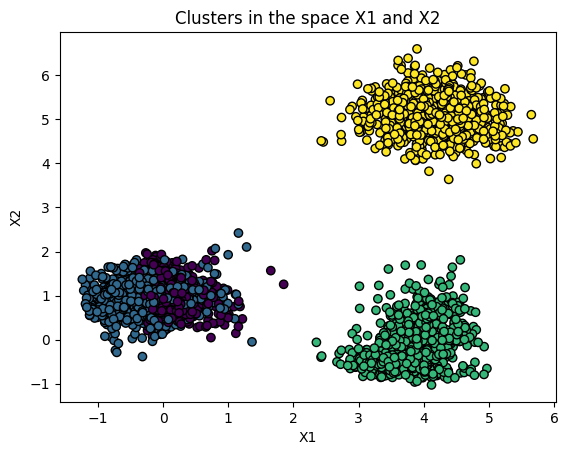

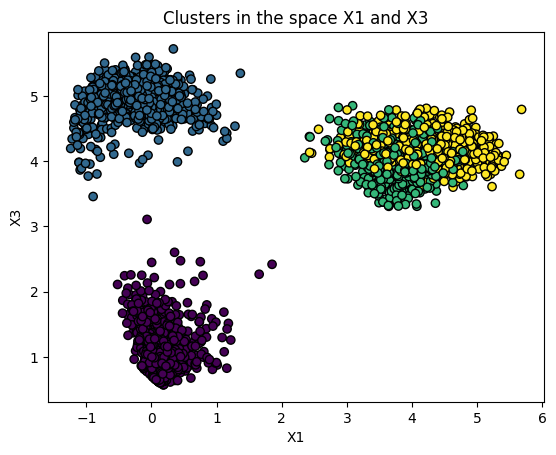

In [11]:
print("------------------------------")
print("AE Fine-tuned , display for X")
print("------------------------------")
plot_synthetic_dataset(X_hat.cpu().detach().numpy(), synthetic_y)

------------------------------
AE Fine-tuned , display for X_Z
------------------------------


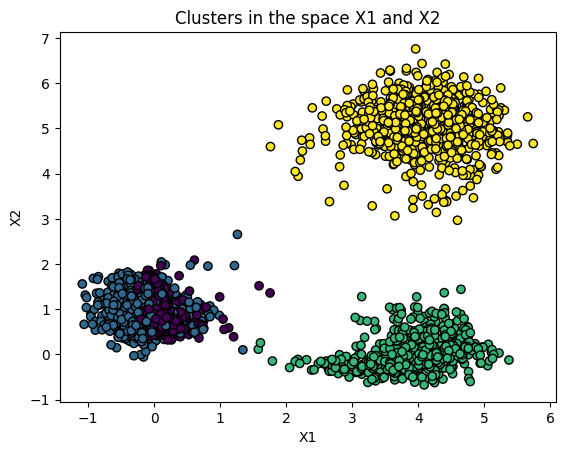

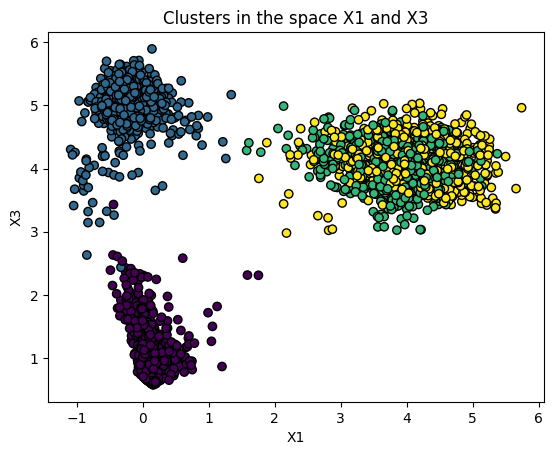

In [12]:
print("------------------------------")
print("AE Fine-tuned , display for X_Z")
print("------------------------------")
plot_synthetic_dataset(X_z_hat.cpu().detach().numpy(), synthetic_y)

In [13]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)

# # encode from X
# H_from_X = ae.encoder(X)

# encode from X_Z
H_from_X_Z = ae.encoder(X_Z)

In [14]:
cluster_dataset = TensorDataset(X_Z, H_from_X_Z, synthetic_y)

BATCH_SIZE = 800
cluster_dataloader = DataLoader(cluster_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 400/400 [01:16<00:00,  5.20it/s]


ClusterHead Training finished!


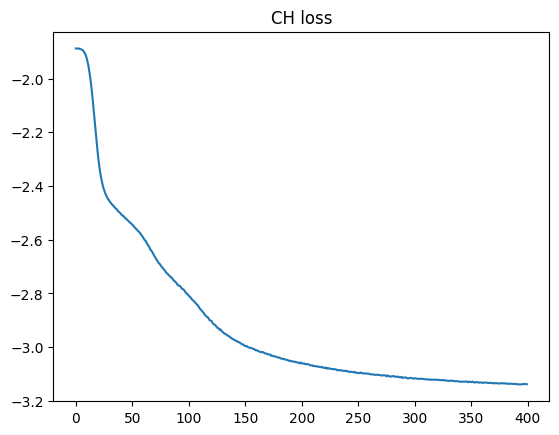

In [28]:
clust = ClusteringNN(13, 8, 2, 4, tau=5)
criterion = ClusterLoss(4, pretrain=True)

clust = clust.to(device)

LR = 1e-2
EPOCHS = 400

optimizer = optim.Adam(clust.cluster_head.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss = criterion(h, clust_logits, aux_logits, u_zg, lmbd, i)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(cluster_dataloader)
    losses.append(avg_epoch_loss)

print('ClusterHead Training finished!')
plt.plot(losses)
plt.title("CH loss")
plt.show()

In [29]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)
H = ae.encoder(X_Z)

clust_logits, aux_logits, u_zg = clust(X_Z, H)
yhat = clust_logits.argmax(dim=1).cpu()

(yhat == synthetic_y).float().mean()

tensor(0.0166)

100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

ClusterHead Training finished!


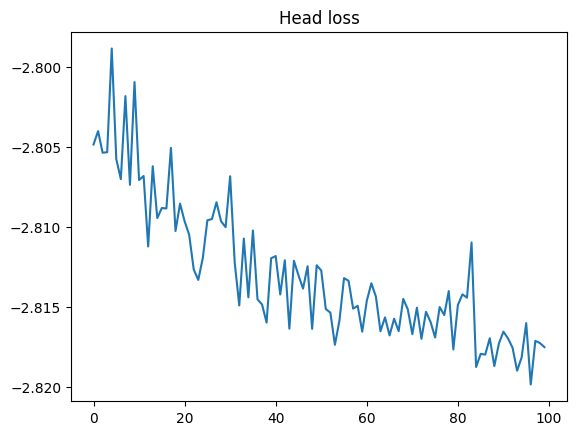

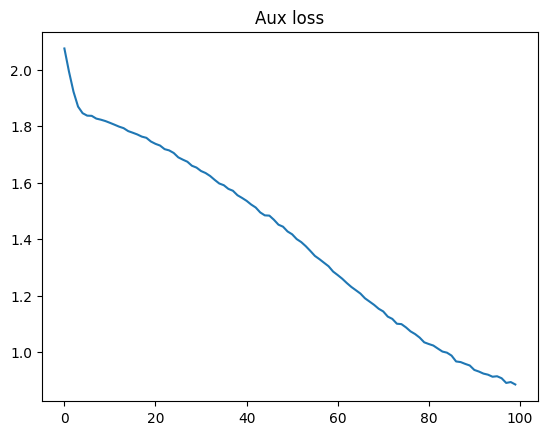

In [17]:
criterion = ClusterLoss(4, pretrain=False)

LR_AUX = 1e-2
LR_ZG = 1e-1

EPOCHS = 100

optimizer_aux = optim.SGD(clust.aux_classifier.parameters(), lr=LR_AUX)
optimizer_ZG = optim.SGD(clust.global_gates.parameters(), lr=LR_ZG)

losses_head = []
losses_aux = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss_head = 0.0
    epoch_loss_aux = 0.0

    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss_head, loss_aux = criterion(h, clust_logits, aux_logits, u_zg, lmbd, i)

        optimizer.zero_grad()
        loss_head.backward(retain_graph=True)
        optimizer.step()

        optimizer_aux.zero_grad()
        optimizer_ZG.zero_grad()
        loss_aux.backward(retain_graph=True)
        optimizer_aux.step()
        optimizer_ZG.step()

        epoch_loss_head += loss_head.item()
        epoch_loss_aux += loss_aux.item()

    # Save the average loss for the epoch
    avg_epoch_loss_head = epoch_loss_head / len(cluster_dataloader)
    losses_head.append(avg_epoch_loss_head)

    avg_epoch_loss_aux = epoch_loss_aux / len(cluster_dataloader)
    losses_aux.append(avg_epoch_loss_aux)

print('ClusterHead Training finished!')

plt.plot(losses_head)
plt.title("Head loss")
plt.show()

plt.plot(losses_aux)
plt.title("Aux loss")
plt.show()

In [21]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)
H = ae.encoder(X_Z)

clust_logits, aux_logits, u_zg = clust(X_Z, H)
yhat = clust_logits.argmax(dim=1).cpu()

(yhat == synthetic_y).float().mean()

tensor(0.1331)

In [19]:
# clust_logits.argmax(dim=1).cpu()

In [20]:
# aux_logits.argmax(dim=1).cpu()